In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import layers

In [57]:
PISTON_LENGTH = 100

In [58]:
actuator_data = []

act_file = open("actuator_data.txt", "r")
while True:
    line = act_file.readline()
    if not line:
        break
    
    line_split = line.split()
    actuator_data.append(line_split)

act_file.close()

In [59]:
actuator_data = np.array(actuator_data)
actuator_data = (actuator_data.astype(np.float64))*PISTON_LENGTH
print(actuator_data.shape)

(6258, 6)


In [60]:
platform_data = []

plt_file = open("platform_data.txt", "r")
while True:
    line = plt_file.readline()
    if not line:
        break
    
    line_split = line.split(",")
    platform_data.append(line_split)

plt_file.close()

In [61]:
platform_data = np.array(platform_data).astype(np.float64)
platform_data_quat = platform_data[:, 3:]
print(platform_data.shape)

(6258, 7)


In [62]:
def quaternion_to_euler_angle_vectorized1(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = np.where(t2>+1.0,+1.0,t2)
    #t2 = +1.0 if t2 > +1.0 else t2

    t2 = np.where(t2<-1.0, -1.0, t2)
    #t2 = -1.0 if t2 < -1.0 else t2
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return [X, Y, Z]

In [63]:
platform_rpy = []

for quat in platform_data_quat:
    platform_rpy.append(quaternion_to_euler_angle_vectorized1(quat[0], quat[1], quat[2], quat[3]))

platform_rpy = np.array(platform_rpy)
print(platform_rpy.shape)

(6258, 3)


In [64]:
x_train, x_test, y_train, y_test = train_test_split(platform_data, actuator_data, test_size=0.15)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5319, 7) (939, 7) (5319, 6) (939, 6)


In [76]:
# IK Model

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='relu')
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 64)                512       
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 6)                 390       
                                                                 
Total params: 17478 (68.27 KB)
Trainable params: 17478 (68.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/100
84/84 [==============================] - 1s 2ms/step - loss: 18.5962 - val_loss: 18.3679
Epoch 2/100
84/84 [==============================] - 0s 1ms/step - loss: 17.9855 - val_loss: 17.3358
Epoch 3/100
84/84 [==============================] - 0s 1ms/step - loss: 16.9243 - val_loss: 16.5425
Epoch 4/100
84/84 [==============================] - 0s 1ms/step - loss: 16.3729 - val_loss: 16.2183
Epoch 5/100
84/84 [==============================] - 0s 1ms/step - loss: 16.0875 - val_loss: 15.9775
Epoch 6/100
84/84 [==============================] - 0s 1ms/step - loss: 15.9159 - val_loss: 15.8642
Epoch 7/100
84/84 [==============================] - 0s 1ms/step - loss: 15.8305 - val_loss: 15.8250
Epoch 8/100
84/84 [==============================] - 0s 1ms/step - loss: 15.7912 - val_loss: 15.7861
Epoch 9/100
84/84 [==============================] - 0s 1ms/step - loss: 15.7658 - val_loss: 15.7794
Epoch 10/100
84/84 [==============================] - 0s 1ms/step - loss: 15.7515 - val_los

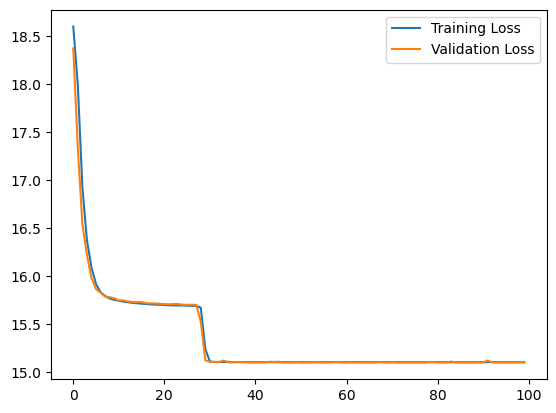

In [78]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [79]:
pred = model.predict(x_test)
error = np.abs(y_test - pred)
avg_error = np.mean(error)
print(avg_error)

30/30 [==============================] - 0s 810us/step
2.7102780689654105
